# Семантическая сегментация. Домашнее задание

В этом домашнем задании вам нужно будет реализовать и обучить модели сегментации родинок

## Датасет

In [1]:
from glob import glob

# from google.colab import drive
# drive.mount('/content/drive/')

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>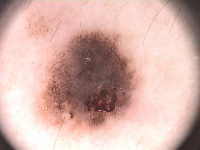</td><td>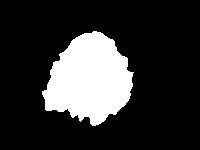</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
#!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [3]:
#get_ipython().system_raw("unrar x PH2Dataset.rar")

In [4]:
!ls PH2Dataset/PH2\ Dataset\ images | wc -l

200


In [5]:
images = glob("PH2Dataset/PH2 Dataset images/*")

### Задание 1 (0.5 балла)

Изучите структуру данных и напишите класс датасета для загрузки изображений с их масками сегментации

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать cv2: [`cv2.imread()`](https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/)

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from glob import glob
import cv2
import numpy as np
import os

class HumanDataset(Dataset):
    def __init__(self, images_paths, transform=None, target_transform=None):
        self.images_paths = images_paths
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        # TODO:
        # 1. Считайте изображение соответствующее индексу
        # 2. Считайте маску сегментации для этого изображения
        # 3. Примените трансформ к изображению и маске
        # 4. Верните изображение и маску
        # Обратите внимание, что значения выходных массивов должны быть типа np.float32 от 0 до 1,
        # и размерность маски должна начинаться с кол-ва каналов - [1, 256, 256]

        obj_id = os.path.basename(self.images_paths[idx])
        image_path = os.path.join(self.images_paths[idx], f"{obj_id}_Dermoscopic_Image", f"{obj_id}.bmp")
        
        image = cv2.imread(image_path)  # BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 2. Формируем путь к маске
        # Предполагается, что путь к маске можно получить заменой поддиректории и имени файла:
        # из .../IMD002_Dermoscopic_Image/IMD002.bmp получаем .../IMD002_lesion/IMD002_lesion.bmp
        mask_path = image_path.replace('_Dermoscopic_Image', '_lesion').replace('.bmp', '_lesion.bmp')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Загружаем маску в градациях серого

        # 3. Приводим к типу np.float32 и нормализуем значения от 0 до 1
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        # 4. Применяем трансформации (если заданы)
        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        if self.target_transform:
            mask = self.target_transform(image=mask)
            mask = mask['image']
        return image, mask

### Задание 2 (0.5 балла)

Разделите датасет на тренировочную, валидационную и тестовую выборки, создайте объекты класса Dataset.
Также выможете дописать свои аугментации. Проверьте, что датасет выводит то что нужно с помощью визуализации. Затем создайте dataloaders для всех выборок.

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(p=1.0)
    ]
)

val_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)

In [9]:
import random

random.shuffle(images)
split_index = int(0.8 * len(images))
train_paths = images[:split_index]
val_paths = images[split_index:]

# TODO: создайте объекты класса HumanDataset для каждой выборки
train_dataset = HumanDataset(train_paths, transform=train_transform, target_transform=train_transform)
val_dataset = HumanDataset(val_paths, transform=val_transform, target_transform=val_transform)

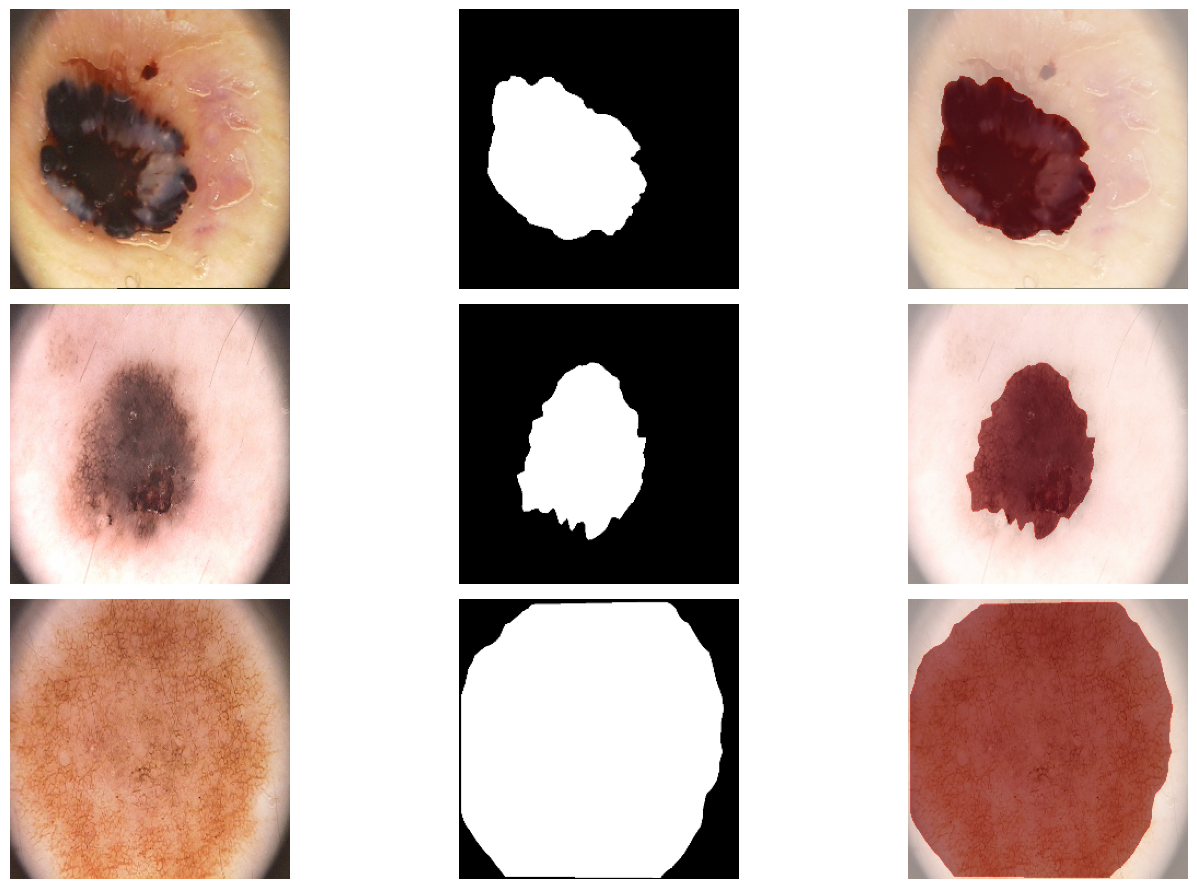

In [12]:
# TODO: визуализируйте элементы датасета

num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))
for i in range(num_samples):
    img, mask = train_dataset[random.randint(0, len(train_dataset)-1)]
    img_np = img.cpu().numpy()
    mask_np = mask.cpu().numpy().squeeze()
    img_np = (img_np * 255).astype(np.uint8)
    axes[i, 0].imshow(img_np.transpose(1, 2, 0))
    axes[i, 0].axis('off')
    axes[i, 1].imshow(mask_np, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(img_np.transpose(1, 2, 0))
    axes[i, 2].imshow(mask_np, cmap='Reds', alpha=0.5)
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [13]:
# TODO: создайте даталодеры для ваших выборок
# Hint: обратите внимание, что валидационную выборку не нужно перемешивать, а батчи должны быть одного размера (в том числе последний)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

## Реализация архитектуры U-Net2

### Задание 3 (1.0 балла)

1. Импортируйте необходимые библиотеки

In [14]:
import torch.nn as nn

2. Реализуйте измененную архитектуру U-Net

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [15]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 256->128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128->64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)  # 64->32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)  # 32->16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16->32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 32->64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 64->128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128->256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1))
        return d3

## Лосс и метрики

### Задание 4 (1 балл)

[**Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$ L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Или в упрощенной форме:

$$ L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$ L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения минорного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$ L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + \sigma(\hat y_i)^\gamma(1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

In [16]:
import torch
import torch.nn.functional as F

def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    """
    Вычисляет Focal Loss для бинарной классификации.

    Аргументы:
        y_real: тензор истинных меток (0 или 1)
        y_pred: тензор логитов (не сигмоидные значения)
        eps: малое значение для численной стабильности (избегаем log(0))
        gamma: параметр фокуса (по умолчанию 2)

    Возвращает:
        Среднее значение Focal Loss по батчу.
    """
    # Применяем сигмоиду для получения вероятностей
    prob = torch.sigmoid(y_pred)
    
    # Потери для положительного класса: y=1
    pos_loss = - ((1 - prob) ** gamma) * y_real * torch.log(prob + eps)
    
    # Потери для отрицательного класса: y=0
    neg_loss = - (prob ** gamma) * (1 - y_real) * torch.log(1 - prob + eps)
    
    # Общая потеря
    loss = pos_loss + neg_loss
    return loss.mean()


### Задание 5 (1 балл)

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$L_D(X,Y) = 1-  \frac{\sum_i 2X_iY_i}{\sum_i (X_i+Y_i)}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [17]:
import torch

def dice_loss(y_real, y_pred, eps=1e-8):
    # Вычисляем сумму произведений (пересечение)
    y_pred = torch.sigmoid(y_pred)
    intersection = torch.sum(y_real * y_pred)
    
    # Вычисляем сумму всех элементов в обеих масках
    total = torch.sum(y_real) + torch.sum(y_pred)
    
    # Вычисляем коэффициент Dice с добавлением eps для стабильности
    dice = (2 * intersection+eps) / (total + eps)
    
    # Dice Loss
    loss = 1 - dice
    return loss


Метрика с семинара

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Ноль если if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Ноль если оба равны 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # Избегаем 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # Сравнение с трэшхолдом

    return thresholded

## Функции для обучения

In [19]:
# визуализация графиков обучения
def visualize(train_loss, val_loss, train_score, val_score, title):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label = 'train_loss')
    plt.plot(val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_score, label = 'train_score')
    plt.plot(val_score, label = 'val_score')
    plt.title('Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')

    plt.suptitle(title, fontsize=16)
    plt.legend()
    plt.show()

In [20]:
#!export LRU_CACHE_CAPACITY=1

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
from IPython.display import clear_output
from time import time
# цикл обучения
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler, path):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    train_loss = []
    val_loss = []
    train_score = []
    val_score = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_train_score = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # перенос на device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # обнуляем градиент в оптимизаторе
            opt.zero_grad()
            # forward
            with torch.set_grad_enabled(True):
                Y_pred = model(X_batch)

                avg_train_score += iou_pytorch(Y_pred>0, Y_batch).mean().item()

                loss =  loss_fn(Y_batch, Y_pred)# forward-pass
                loss.backward()  # backward-pass
                opt.step()  # обновление весов

                scheduler.step() # лучше выключить при обучении своей сети без претрейна
            # суммируем лосс чтобы вывести график
            avg_loss += loss / len(data_tr)

        avg_train_score = avg_train_score / len(data_tr)

        train_score.append(avg_train_score)
        train_loss.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        avg_val_loss = 0
        avg_val_score = 0
        # промежуточные результаты
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                # перенос на device
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                # forward
                Y_val_pred = model(X_val_batch)
                vall_loss =  loss_fn(Y_val_batch, Y_val_pred)# forward-pass
                avg_val_score += iou_pytorch(Y_val_pred >0, Y_val_batch).mean().item()
                # суммируем лосс
                avg_val_loss += vall_loss / len(data_val)

        val_loss.append(avg_val_loss)
        avg_val_score = avg_val_score / len(data_val)
        val_score.append(avg_val_score)

        Y_hat = model(X_val).detach().cpu() # перенос на cpu

        # Визуализация
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    torch.save(model, path)
    return train_loss, val_loss, train_score, val_score

In [23]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    #model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred>0, Y_label.to(device)).mean().item()
    return scores/len(data)

In [24]:
def model_scorerer(model_class, path, max_epochs, loss, data_tr, data_val):
    model_name = str(model_class).split()[0][:-1]
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model_class.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

## Обучение

### Задание 6 (1.5 балла)

Обучите модель U-Net2 с focal-loss, напишите выводы и кратко о своих экспериментах, результатах.

In [187]:
torch.cuda.empty_cache()

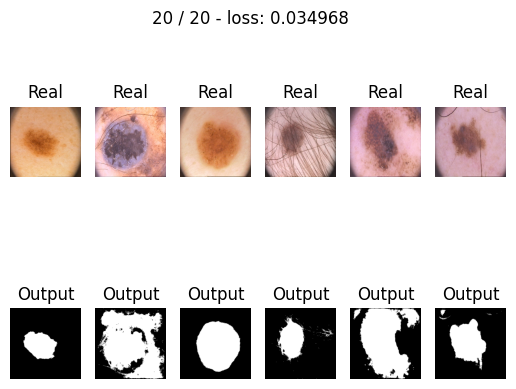

Working with UNet2 and focal_loss
validation score: 0.675000011920929


In [188]:
train_loss_unet_focal, val_loss_unet_focal, train_score_unet_focal, val_score_unet_focal, model_unet_focal = \
model_scorerer(UNet2(), "unet_focal.pt", 20, focal_loss, train_dataloader, val_dataloader)

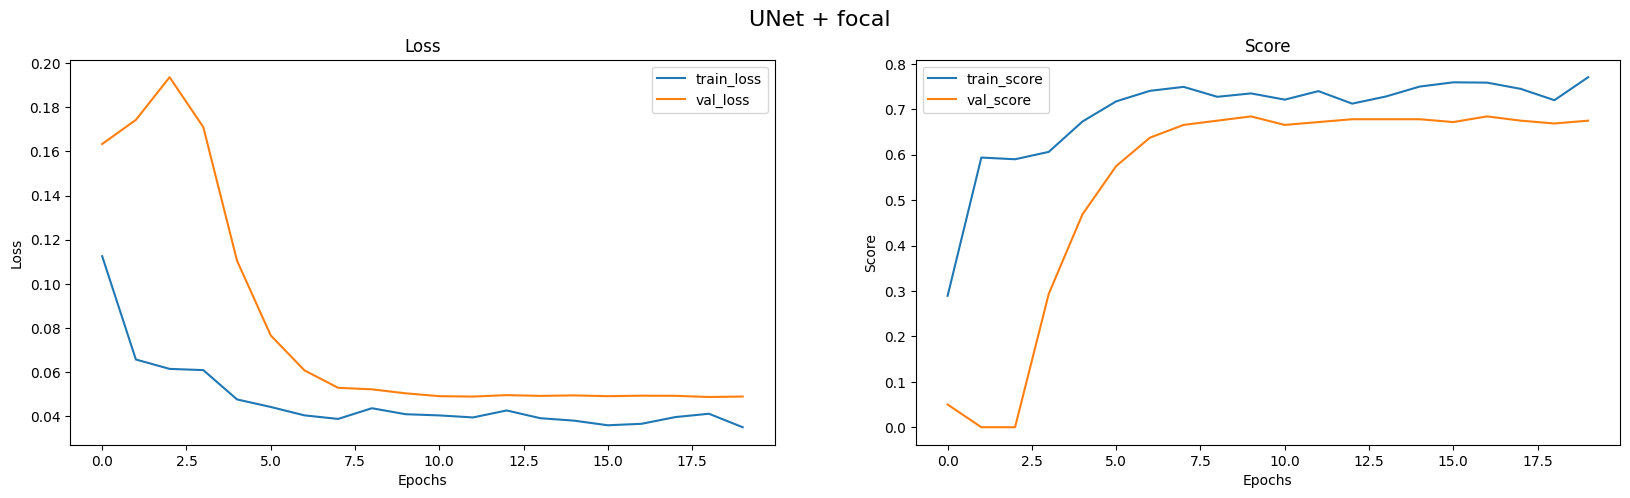

In [189]:
train_loss_unet_focal = [x.cpu().detach().numpy() for x in train_loss_unet_focal]
val_loss_unet_focal = [x.cpu().detach().numpy() for x in val_loss_unet_focal]

visualize(train_loss_unet_focal, val_loss_unet_focal,
          train_score_unet_focal, val_score_unet_focal, "UNet + focal")

### Задание 7 (1.5 балла)

Обучите модель U-Net2 с dice-locc, напишите выводы и кратко о своих экспериментах, результатах.

In [235]:
torch.cuda.empty_cache()

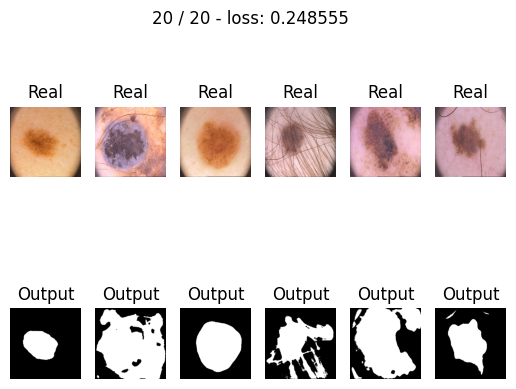

Working with UNet2 and dice_loss
validation score: 0.6250000298023224


In [236]:
train_loss_unet_dice, val_loss_unet_dice, train_score_unet_dice, val_score_unet_dice, model_unet_dice = \
model_scorerer(UNet2(), "unet_dice.pt", 20, dice_loss, train_dataloader, val_dataloader)

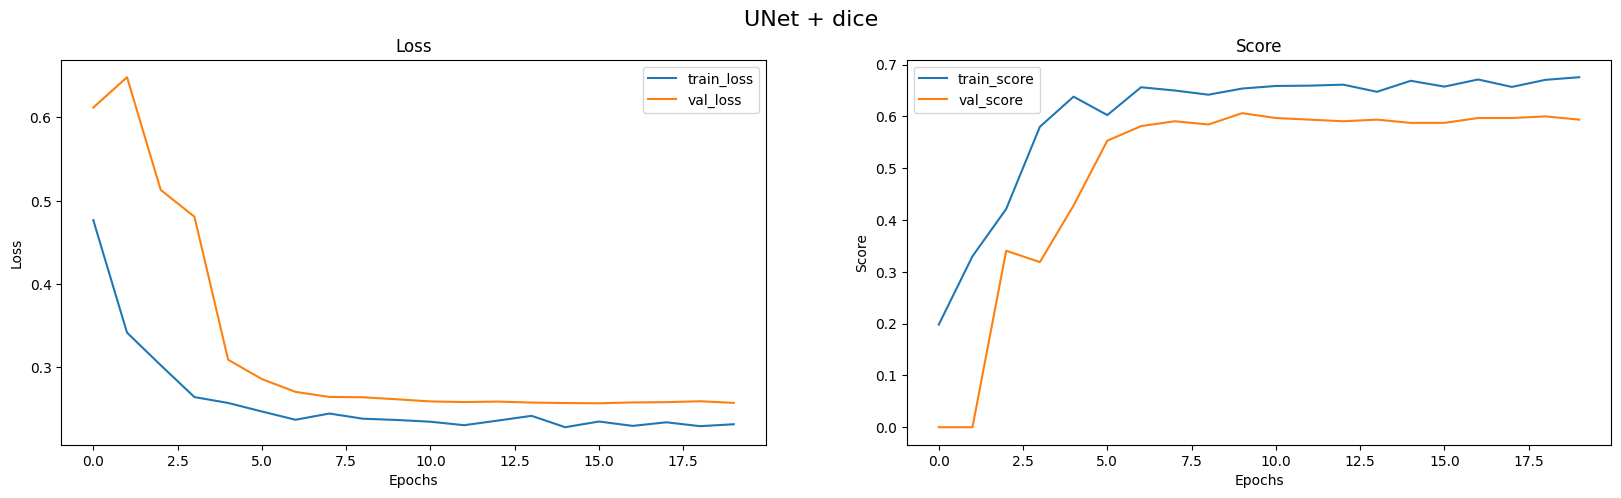

In [233]:
train_loss_unet_dice = [x.cpu().detach().numpy() for x in train_loss_unet_dice]
val_loss_unet_dice = [x.cpu().detach().numpy() for x in val_loss_unet_dice]
visualize(train_loss_unet_dice, val_loss_unet_dice,
          train_score_unet_dice, val_score_unet_dice, "UNet + dice")

**Выводы:**  

*Focal loss:*

- IoU score на валидации: **0.675**
- запустился сразу и выдал хороший бейзлайновый результат

*Dice loss:*

- IoU score на валидации: **0.625**
- Долго тупил, что нужно сигмоиду накинуть на предсказания. Без нее не работало.
- Добавочное слагаемое в числителе и знаменателе решает (попробовал $\varepsilon=1$ и $\varepsilon=10^{-8}$, меньший показал лучший результат)

Видно по графикам, что начиная с 10 эпохи, наступает переобучение.

## Обучение с помощью mmsegmentation

### Задание 8 (0.5 балла)

Установите необходимые зависимости и импортируйте библиотеки

In [ ]:
!pip install torch==2.0.0 torchvision==0.15.1
!pip install -U openmim
!mim install mmengine
!mim install mmcv==2.0.0
!pip install --no-cache-dir mmsegmentation

### Задание 9 (0.5 балла)

Напишите класс модели, которая будет состоять из бэкбона MobileNetV3 и головы FCNHead

In [ ]:
# TODO: импортируйте нужные модули из mmseg

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mmseg.models.backbones import MobileNetV3
from mmseg.models.decode_heads import FCNHead

class TinyModel(nn.Module):
    def __init__(self, num_classes=21):
        super(TinyModel, self).__init__()
        # Инициализируем бэкбон MobileNetV3 (используем вариант 'small')
        # out_indices=(3,) означает, что мы берем выход с одного выбранного уровня
        self.backbone = MobileNetV3(arch='small', out_indices=(3,))
        
        # Инициализируем голову FCNHead.
        # Параметр in_channels должен соответствовать числу каналов на выбранном уровне бэкбона.
        # Здесь предполагается, что для MobileNetV3 small на выбранном уровне выход имеет 576 каналов.
        self.head = FCNHead(
            in_channels=24,
            channels=256,
            num_classes=num_classes,
            in_index=0  # если бэкбон возвращает список, берем первый (и единственный) элемент
        )

    def forward(self, x):
        # Получаем признаки из бэкбона
        feats = self.backbone(x)
        # Если признаки не упакованы в список/кортеж, оборачиваем их
        if not isinstance(feats, (list, tuple)):
            feats = [feats]
        # Получаем предсказание головы по полученным признакам
        out = self.head(feats)
        # Интерполируем (upsample) выходную маску до размера входного изображения
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out


Загрузите предобученные веса для бэкбона

In [43]:
#!wget https://download.openmmlab.com/mmsegmentation/v0.5/mobilenet_v3/lraspp_m-v3s-d8_512x1024_320k_cityscapes/lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth

In [44]:
tiny_model = TinyModel(num_classes=1)

In [45]:
model_name = 'lraspp_m-v3s-d8_512x1024_320k_cityscapes_20201224_223935-61565b34.pth'
w = torch.load(model_name, map_location='cpu');
w_backbone = {k.replace('backbone.', ''):v for k,v in w['state_dict'].items() if k.startswith('backbone.')}
tiny_model.backbone.load_state_dict(w_backbone)

<All keys matched successfully>

Проверьте вывод полученной модели

In [46]:
X_val_batch = next(iter(val_dataloader))[0]

In [47]:
out = tiny_model(X_val_batch)

In [50]:
out.shape

torch.Size([16, 1, 256, 256])

### Задание 10 (1.5 балла)


Обучите модель с помощью тех же функций для обучения

In [51]:
def model_scorerer(model, model_name, path, max_epochs, loss, data_tr, data_val):
    loss_name = str(loss).split()[1]
    title = f"Working with {model_name} and {loss_name}"

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    train_loss, val_loss, train_score, val_score = \
    train(model, optimizer, loss, max_epochs, data_tr, data_val, scheduler, path)

    # print()
    # visualize(train_loss.cpu().numpy(), val_loss.cpu().numpy(), train_score, val_score, title)

    print(title)
    print(f"validation score: {score_model(model, iou_pytorch, data_val)}")
    return train_loss, val_loss, train_score, val_score, model

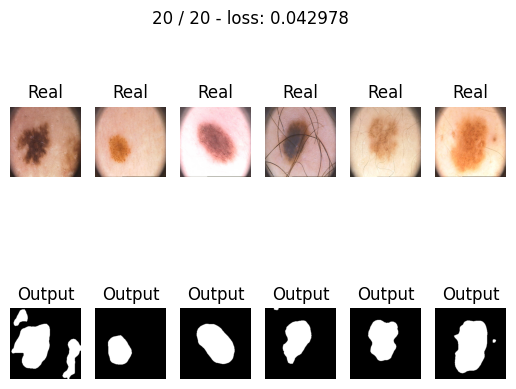

Working with MobileNet+FCNHead and focal_loss
validation score: 0.7437500357627869


In [52]:
train_loss, val_loss, train_score, val_score, model = \
model_scorerer(tiny_model, "MobileNet+FCNHead", "MobileNet+FCNHead.pt", 20, focal_loss, train_dataloader, val_dataloader)

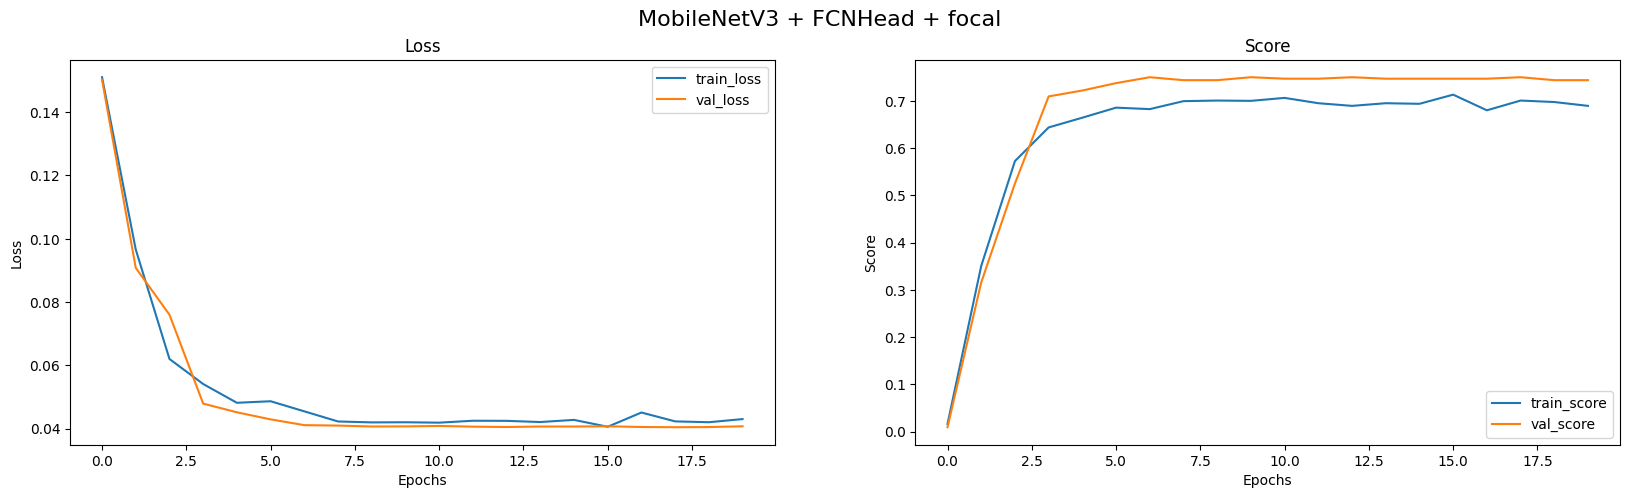

In [53]:
train_loss = [x.cpu().detach().numpy() for x in train_loss]
val_loss = [x.cpu().detach().numpy() for x in val_loss]

visualize(train_loss, val_loss,
          train_score, val_score, "MobileNetV3 + FCNHead + focal")

## Выводы ( за отсутствие ноль баллов за 10 Задание)

Сравните ваши эксперименты, сделайте выводы. Ответьте на следующие вопросы:
1. Не переобучаются ли ваши нейронные сети?
2. Достигаются ли максимально возможные метрики в каждом из экспериментов?
3. Как повлияла функция лосса на результаты, скорость и качество обучения?
4. Какой эксперимент дает наилучшие результаты?

**Ответ**:

- Как и ранее было упомянуто, нейросети очевидно переобучаютсяю
- Максимально возможные метрики не достигаются, потому что не был проведен перебор параметров. Например, даже изменение $\varepsilon$ в dice_loss влияет на метрику.
- Focal loss лучше себя показывает в данной задаче: как по скорости (быстрее), так и по качеству (лучше)
- Наилучший результат показал себя Tiny_model с focal_loss.